# `dtreeviz` LightGBM Examples

([View this notebook in Colab](https://colab.research.google.com/github/parrt/dtreeviz/blob/master/notebooks/dtreeviz_lightgbm_visualisations.ipynb))

The [dtreeviz](https://github.com/parrt/dtreeviz) library is designed to help machine learning practitioners visualize and interpret decision trees and decision-tree-based models, such as gradient boosting machines.  

The purpose of this notebook is to illustrate the main capabilities and functions of the dtreeviz API. To do that, we will use LightGBM and the toy but well-known Titanic data set for illustrative purposes.  Currently, dtreeviz supports the following decision tree libraries:

* [scikit-learn](https://scikit-learn.org/stable)
* [XGBoost](https://xgboost.readthedocs.io/en/latest)
* [Spark MLlib](https://spark.apache.org/mllib/)
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
* [Tensorflow](https://www.tensorflow.org/decision_forests)

To interopt with these different libraries, dtreeviz uses an adaptor object, obtained from function `dtreeviz.model()`, to extract model information necessary for visualization. Given such an adaptor object, all of the dtreeviz functionality is available to you using the same programmer interface. The basic dtreeviz usage recipe is:

1. Import dtreeviz and your decision tree library
2. Acquire and load data into memory
3. Train a classifier or regressor model using your decision tree library
4. Obtain a dtreeviz adaptor model using<br>`viz_model = dtreeviz.model(your_trained_model,...)`
5. Call dtreeviz functions, such as<br>`viz_model.view()` or `viz_model.explain_prediction_path(sample_x)`

The four categories of dtreeviz functionality are:

1. Tree visualizations
2. Prediction path explanations
3. Leaf information
4. Feature space exploration

We have grouped code examples by [classifiers](#Classifiers) and [regressors](#Regressors), with a follow up section on [partitioning feature space](#Feature-Space-Partitioning).

*These examples require dtreeviz 2.0 or above because the code uses the new API introduced in 2.0.*

## Setup

In [1]:
import sys
import os

In [2]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz
  !pip install -q lightgbm

In [3]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import dtreeviz

random_state = 1234 # get reproducible trees

## Load Sample Data

In [4]:
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/titanic/titanic.csv"
dataset = pd.read_csv(dataset_url)
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

# Classifiers

To demonstrate classifier decision trees, we trying to model using six features to predict the boolean survived target.

In [5]:
features = ["Pclass", "Sex_label", "Embarked_label", "Age", "Cabin_label", "Fare"]
target = "Survived"

X_train, X_test, y_train, y_test = train_test_split(dataset[features], dataset[target], test_size=0.2, random_state=42)

train_data = lgb.Dataset(data=X_train, label=y_train, feature_name=features, categorical_feature=["Sex_label", "Pclass"])
valid_data = lgb.Dataset(data=X_test, label=y_test, feature_name=features, categorical_feature=["Sex_label", "Pclass"])

lgbm_params = {
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'binary',     # Binary classification
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 2,      # Data set is quite small so reduce this a bit
    'feature_pre_filter': False,
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}

lgbm_model = lgb.train(lgbm_params, train_data, valid_sets=[train_data, valid_data], verbose_eval=False)



/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.


[LightGBM] [Info] Number of positive: 268, number of negative: 444
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.376404 -> initscore=-0.504838
[LightGBM] [Info] Start training from score -0.504838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

## Initialize dtreeviz model (adaptor)

To adapt dtreeviz to a specific model, use the `model()` function to get an adaptor.  You'll need to provide the model, X/y data, feature names, target name, and target class names:

In [6]:
viz_model = dtreeviz.model(lgbm_model, tree_index=1,
                           X_train=dataset[features], y_train=dataset[target],
                           feature_names=features,
                           target_name=target, class_names=["perish", "survive"])

We'll use this model to demonstrate dtreeviz functionality in the following sections; the code will look the same for any decision tree library once we have this model adaptor.

## Tree structure visualizations

To show the decision tree structure using the default visualization, call `view()`:

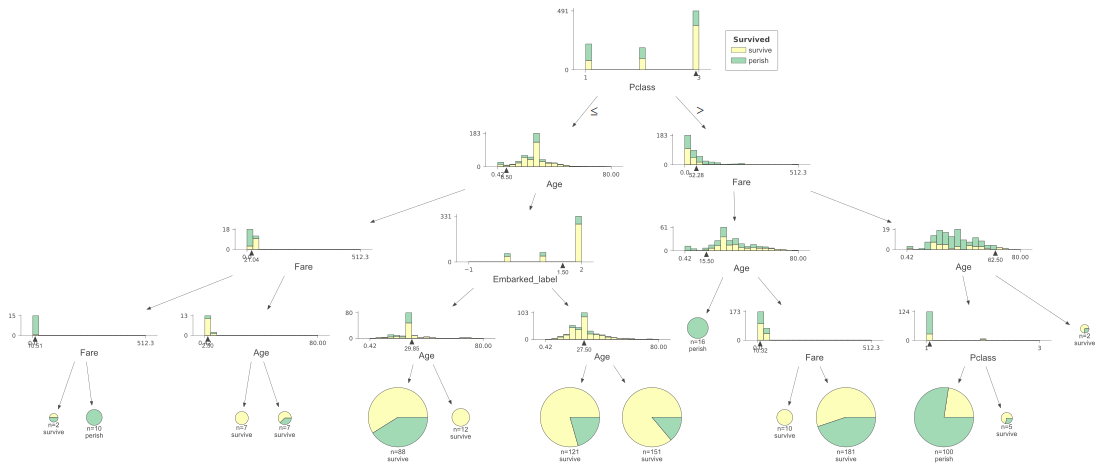

In [7]:
viz_model.view()

To change the visualization, you can pass parameters, such as changing the orientation to left-to-right:

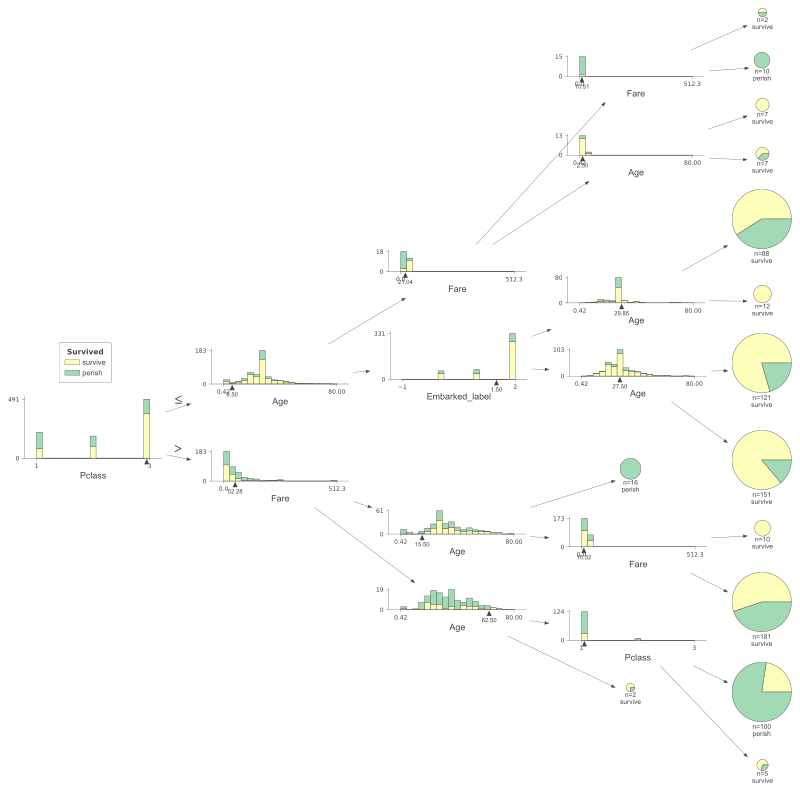

In [8]:
viz_model.view(orientation="LR")

To visualize larger trees, you can reduce the amount of detail by turning off the fancy view:

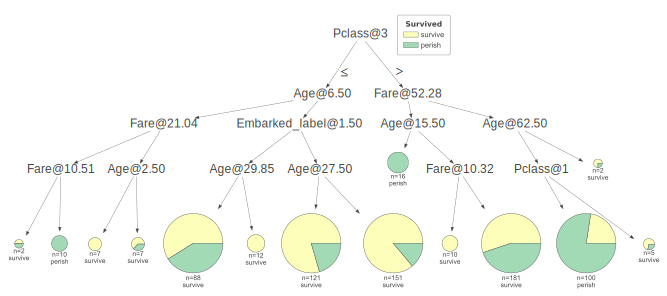

In [9]:
viz_model.view(fancy=False)

Another way to reduce the visualization size is to specify the tree depths of interest:

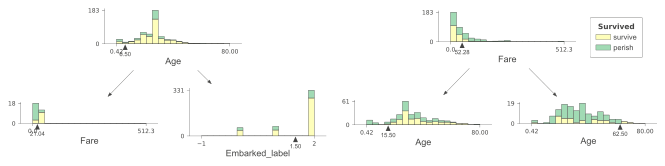

In [10]:
viz_model.view(depth_range_to_display=(1, 2)) # root is level 0

## Prediction path explanations

For interpretation purposes, we often want to understand how a tree behaves for a specific instance. Let's pick a specific instance:

In [11]:
x = dataset[features].iloc[10]
x

Pclass              3.0
Sex_label           0.0
Embarked_label      2.0
Age                 4.0
Cabin_label       145.0
Fare               16.7
Name: 10, dtype: float64

and then display the path through the tree structure:

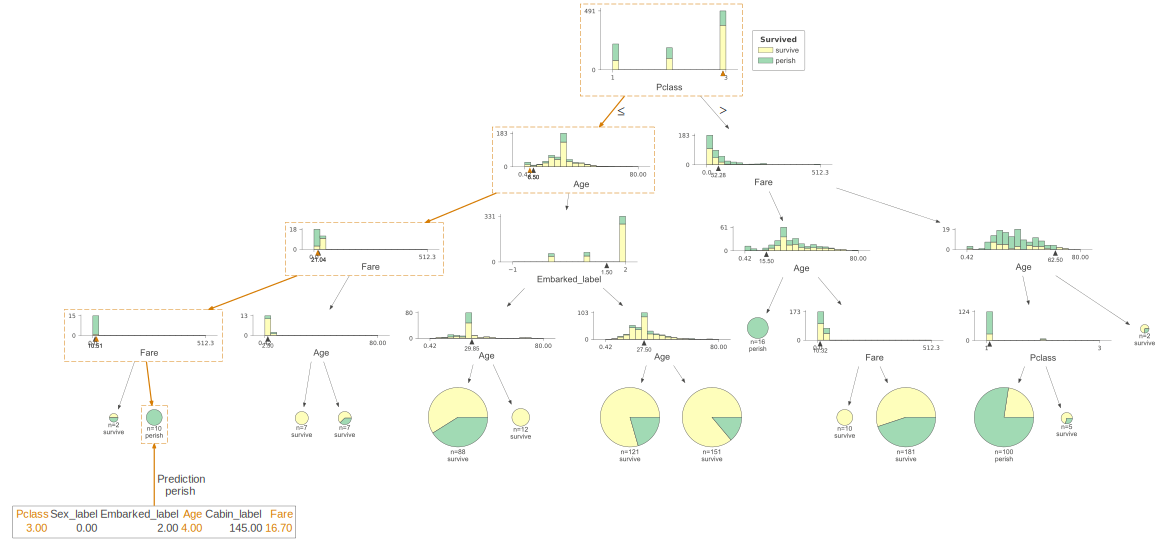

In [12]:
viz_model.view(x=x)

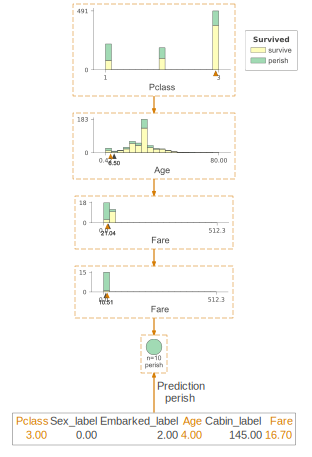

In [13]:
viz_model.view(x=x, show_just_path=True)

You can also get a string representation explaining the comparisons made as an instance is run down the tree:

In [14]:
print(viz_model.explain_prediction_path(x))

Age < 6.5
10.51 <= Fare  < 21.04
Pclass in {3}  



## Leaf info

There are a number of functions to get information about the leaves of the tree.

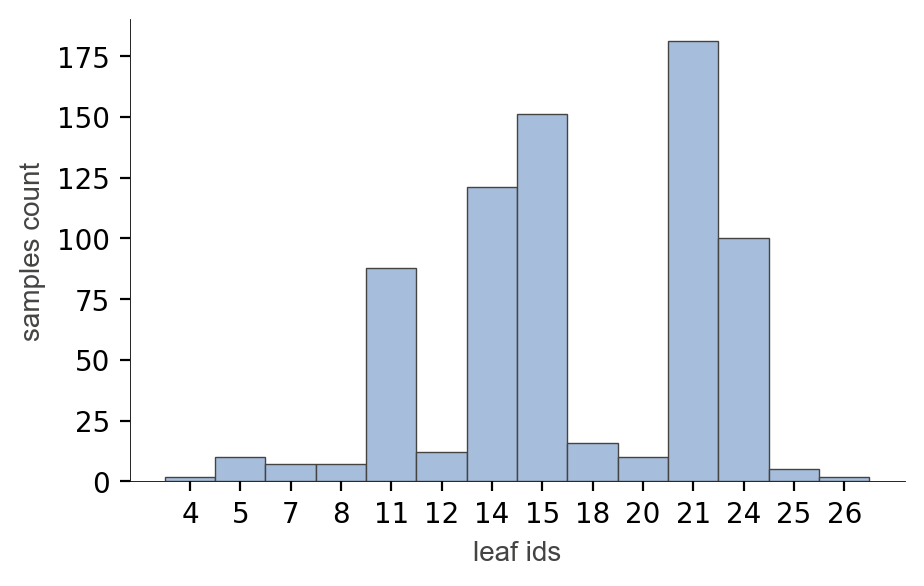

In [15]:
viz_model.leaf_sizes()

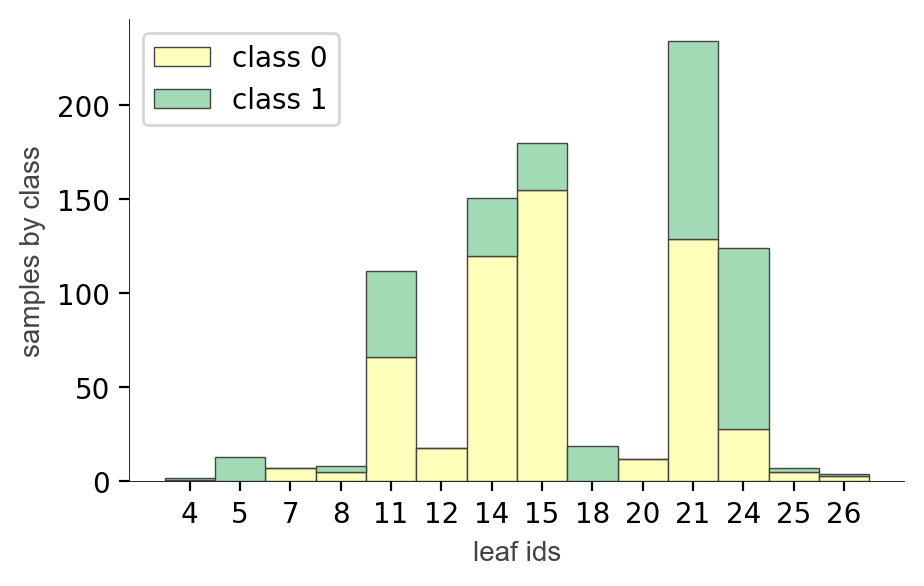

In [16]:
viz_model.ctree_leaf_distributions()

In [17]:
viz_model.node_stats(node_id=21)

Pclass   Sex_label  Embarked_label         Age  Cabin_label  \
count  234.000000  234.000000      234.000000  234.000000   234.000000   
mean     1.649573    0.658120        1.662393   35.832388    21.782051   
std      0.478127    0.475357        0.742138   12.681008    42.369916   
min      1.000000    0.000000        0.000000   16.000000    -1.000000   
25%      1.000000    0.000000        2.000000   28.000000    -1.000000   
50%      2.000000    1.000000        2.000000   32.000000    -1.000000   
75%      2.000000    1.000000        2.000000   44.000000    23.250000   
max      2.000000    1.000000        2.000000   80.000000   146.000000   

             Fare  
count  234.000000  
mean    23.759009  
std     11.285105  
min     10.500000  
25%     13.000000  
50%     26.000000  
75%     29.700000  
max     52.000000

# Regressors

To demonstrate regressor tree visualization, we start by creating a regressors model that predicts age instead of survival:

In [18]:
features_reg = ["Pclass", "Fare", "Survived", "Sex_label", "Cabin_label", "Embarked_label"]
target_reg = "Age"

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(dataset[features_reg], dataset[target_reg], test_size=0.2, random_state=42)

categorical_feature=["Pclass", "Survived", "Sex_label"]
train_data_reg = lgb.Dataset(data=X_train_reg, label=y_train_reg)
valid_data_reg = lgb.Dataset(data=X_test_reg, label=y_test_reg)

lgbm_params = {
    'num_tree':10,
    'boosting': 'dart',          # dart (drop out trees) often performs better
    'application': 'regression_l1',     
    'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    'drop_rate': 0.15,
    'max_depth':4,
    "seed":1212}

lgbm_reg_model = lgb.train(lgbm_params, train_data_reg, valid_sets=[train_data_reg, valid_data_reg], categorical_feature=categorical_feature, verbose_eval=False)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004805 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 6
[LightGBM] [Info] Start training from score 29.699118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no

/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_tree` in params. Will use it instead of argument
/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Pclass', 'Sex_label', 'Survived']
/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
/Users/parrt/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.


## Initialize dtreeviz model (adaptor)

In [19]:
viz_rmodel = dtreeviz.model(model=lgbm_reg_model, tree_index=1,
                            X_train=dataset[features_reg], 
                            y_train=dataset[target_reg], 
                            feature_names=features_reg, 
                            target_name=target_reg)

## Tree structure visualisations

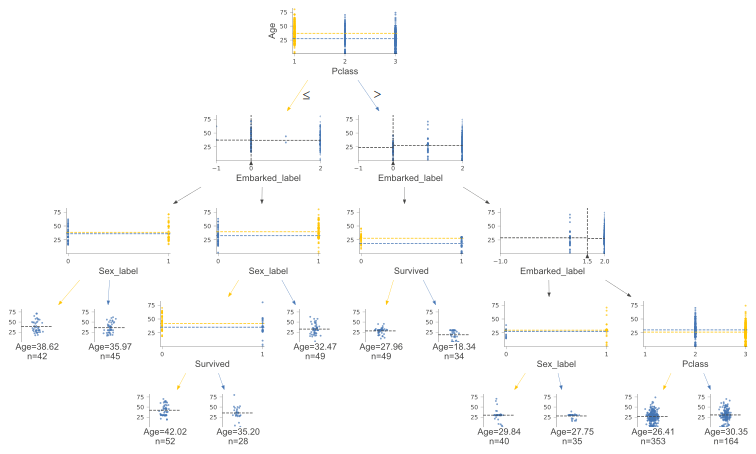

In [20]:
viz_rmodel.view()

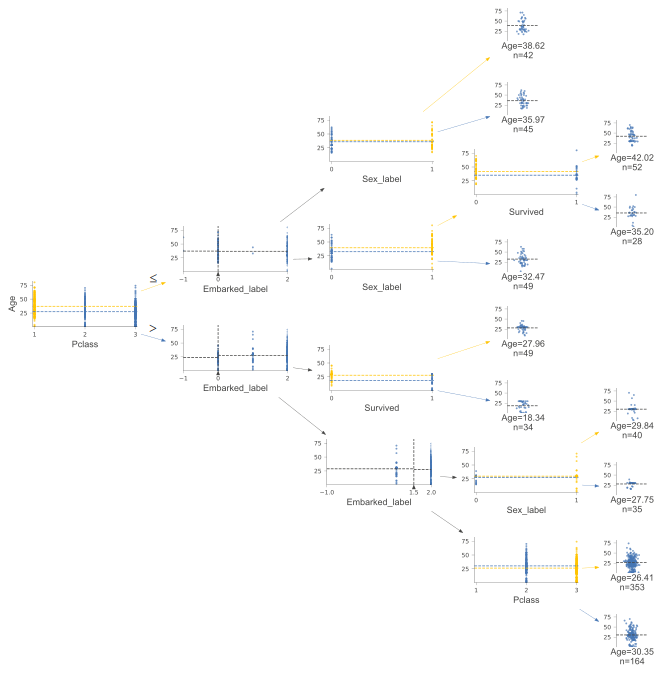

In [21]:
viz_rmodel.view(orientation="LR")

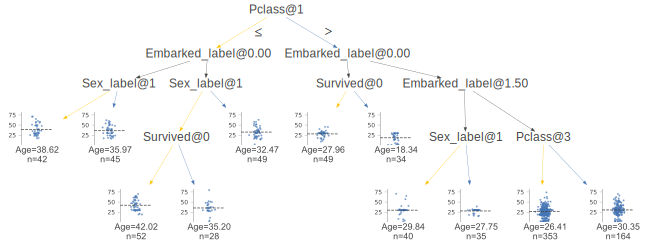

In [22]:
viz_rmodel.view(fancy=False)

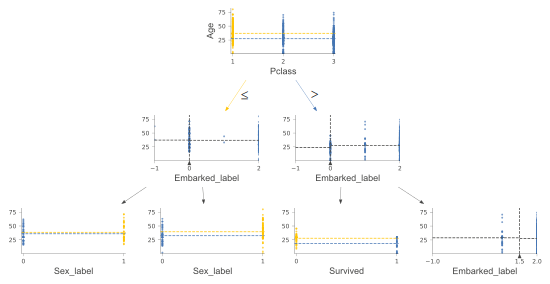

In [23]:
viz_rmodel.view(depth_range_to_display=(0, 2))

## Prediction path explanations

In [24]:
x = dataset[features_reg].iloc[10]
x

Pclass              3.0
Fare               16.7
Survived            1.0
Sex_label           0.0
Cabin_label       145.0
Embarked_label      2.0
Name: 10, dtype: float64

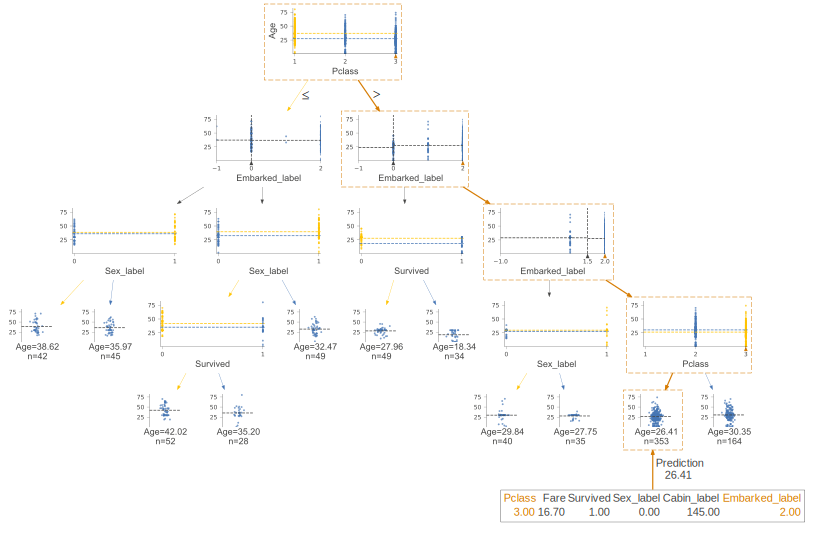

In [25]:
viz_rmodel.view(x = x)

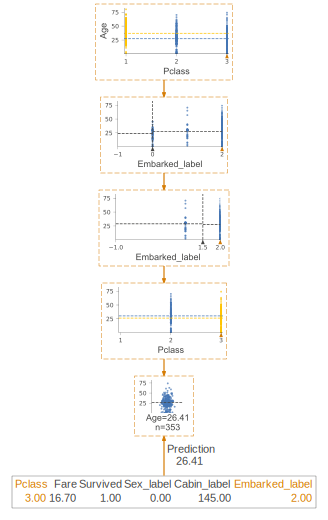

In [26]:
viz_rmodel.view(show_just_path=True, x = x)

In [27]:
print(viz_rmodel.explain_prediction_path(x))

1.5 <= Embarked_label 
Pclass in {3} not in {1}  



## Leaf info

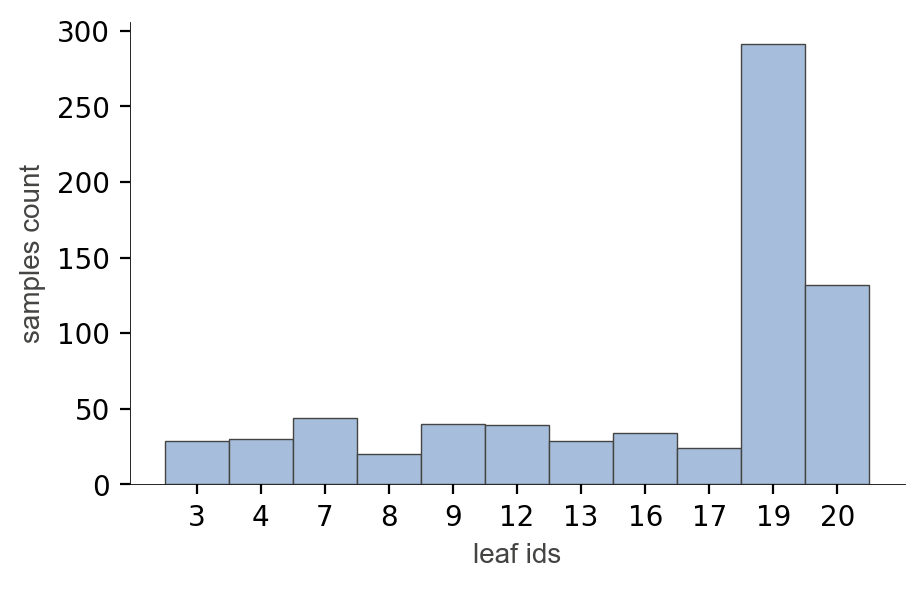

In [28]:
viz_rmodel.leaf_sizes()

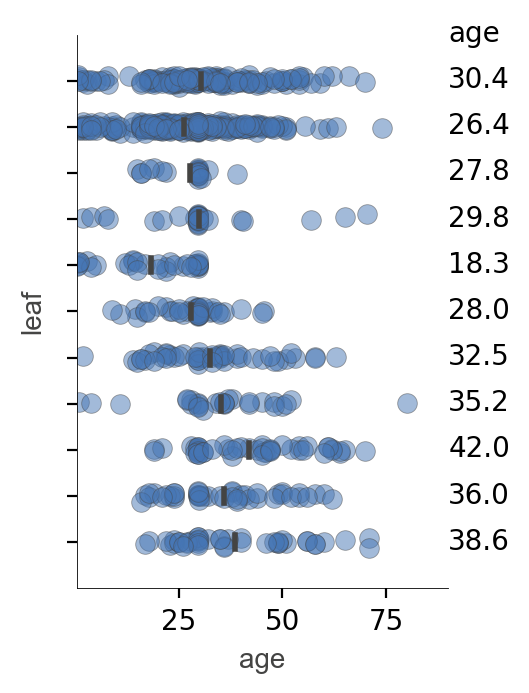

In [29]:
viz_rmodel.rtree_leaf_distributions()

In [30]:
viz_rmodel.node_stats(node_id=19)

Pclass        Fare    Survived   Sex_label  Cabin_label  Embarked_label
count   353.0  353.000000  353.000000  353.000000   353.000000           353.0
mean      3.0   14.644083    0.189802    0.750708     2.852691             2.0
std       0.0   13.276609    0.392701    0.433217    22.686371             0.0
min       3.0    0.000000    0.000000    0.000000    -1.000000             2.0
25%       3.0    7.854200    0.000000    1.000000    -1.000000             2.0
50%       3.0    8.050000    0.000000    1.000000    -1.000000             2.0
75%       3.0   16.100000    0.000000    1.000000    -1.000000             2.0
max       3.0   69.550000    1.000000    1.000000   145.000000             2.0

# Feature Space Partitioning

Decision trees partition feature space in such a way as to maximize target value purity for the instances associated with a node. It's often useful to visualize the feature space partitioning, although it's not feasible to visualize more than a couple of dimensions.

*work in progress for this library*

See [Feature Space Partitioning for scikit-learn](dtreeviz_sklearn_visualisations.ipynb#Feature_Space_Partitioning) for now.